# Train CNN on MNIST

We need to train to do regression on the one-hot MNIST labels.

torch.Size([50000, 3, 32, 32])
torch.Size([3])
tensor(1.) tensor(0.) tensor(0.4734) torch.Size([50000, 3, 32, 32])


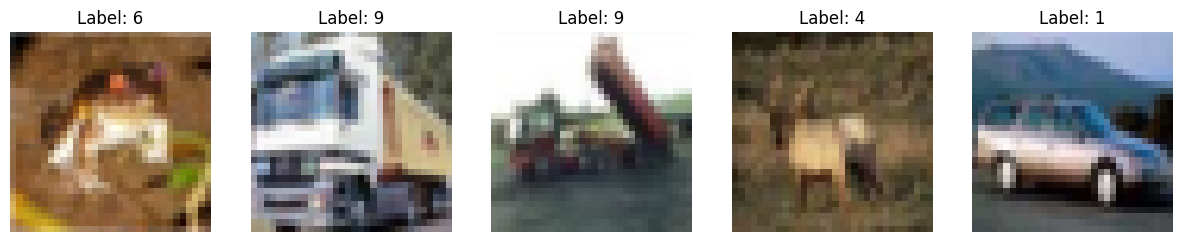

In [1]:
import torch
import torch.optim as optim
from torch.utils.data import TensorDataset, DataLoader

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# ---- Load MNIST data ----
from torchvision.datasets import CIFAR10

train_cifar_images = (
    torch.tensor(CIFAR10(root="./data", train=True, download=True).data)
    .to(device)
    .permute(0, 3, 1, 2)
    .float()
    / 255.0
)
train_cifar_labels = torch.tensor(
    CIFAR10(root="./data", train=True, download=True).targets, device=device
)
cifar_mean, cifar_std = train_cifar_images.mean(dim=(0, 2, 3)), train_cifar_images.std(
    dim=(0, 2, 3)
)
print(train_cifar_images.shape)
print(cifar_mean.shape)

test_cifar_images = (
    torch.tensor(CIFAR10(root="./data", train=False, download=True).data)
    .to(device)
    .permute(0, 3, 1, 2)
    .float()
    / 255.0
)
test_cifar_labels = torch.tensor(
    CIFAR10(root="./data", train=False, download=True).targets, device=device
)

print(
    train_cifar_images.max(),
    train_cifar_images.min(),
    train_cifar_images.mean(),
    train_cifar_images.shape,
)


# Show a few images
import matplotlib.pyplot as plt

fig, axs = plt.subplots(1, 5, figsize=(15, 3))
for i in range(5):
    axs[i].imshow(train_cifar_images[i].permute(1, 2, 0).cpu())
    axs[i].set_title(f"Label: {train_cifar_labels[i]}")
    axs[i].axis("off")
plt.show()

train_ds = TensorDataset(
    train_cifar_images,
    torch.nn.functional.one_hot(train_cifar_labels, num_classes=10),
)

test_ds = TensorDataset(test_cifar_images, test_cifar_labels)

train_loader = DataLoader(train_ds, batch_size=64, shuffle=True)
test_loader = DataLoader(test_ds, batch_size=256)

In [ ]:
# ---- Define CNN model ----
from models.cifar_cnn import CifarConvNet, BiggerCifarConvNet

# ---- Initialize model, loss, optimizer ----
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Load pre-trained model if available
from pathlib import Path

# model_path = Path("models/cifar_cnn.pth")
# if model_path.exists():
#     model = CifarConvNet().to(device)
#     model.load_state_dict(torch.load(model_path))
#     print("Loaded pre-trained model.")
# else:
#     model = CifarConvNet(cifar_mean, cifar_std).to(device)

model_path = Path("models/cifar_bigger_cnn.pth")
if model_path.exists():
    model = BiggerCifarConvNet().to(device)
    model.load_state_dict(torch.load(model_path))
    print("Loaded pre-trained model.")
else:
    model = BiggerCifarConvNet(cifar_mean, cifar_std).to(device)


# criterion = torch.nn.SmoothL1Loss()
criterion = torch.nn.MSELoss()


optimizer = optim.Adam(model.parameters(), lr=1e-6)
# optimizer = torch.optim.SGD(model.parameters(), lr=0.001, momentum=0.9)


# ---- Training loop ----
for epoch in range(20):
    model.train()
    total_loss = 0
    for xb, yb in train_loader:
        xb, yb = xb.to(device), yb.to(device)
        optimizer.zero_grad()
        outputs = model(xb)
        preds = torch.softmax(outputs, dim=1)
        loss = criterion(preds, yb.float())
        loss.backward()
        optimizer.step()
        total_loss += loss.item()

    print(f"Epoch {epoch+1}: train_loss = {total_loss / len(train_loader):.4f}")


# ---- Evaluation ----
model.eval()
correct = 0
total = 0
with torch.no_grad():
    for xb, yb in test_loader:
        xb, yb = xb.to(device), yb.to(device)
        outputs = model(xb)
        predicted = torch.argmax(outputs, 1)
        total += yb.size(0)
        correct += (predicted == yb).sum().item()

print(f"Test accuracy: {correct / total:.4f}")

# ---- Save model ----
torch.save(model.state_dict(),model_path)